<a href="https://colab.research.google.com/github/gyunini/DeepLearning_From_Scratch/blob/main/%EB%B0%91%EC%8B%9C%EB%94%A5ch08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import sys, os
sys.path.append('/content/drive/MyDrive/Colab Notebooks/2023_AI')
sys.path.extend("./")
from mnist import load_mnist

## 필요 함수, 클래스들

In [15]:
# coding: utf-8
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad


def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

In [16]:
# coding: utf-8
import numpy as np


def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용

    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.

    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블

    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).

    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩

    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.

    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩

    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [17]:
# coding: utf-8
import numpy as np


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var

        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)

        return out.reshape(*self.input_shape)

    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))

        out = self.gamma * xn + self.beta
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx


class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        # 중간 데이터（backward 시 사용）
        self.x = None
        self.col = None
        self.col_W = None

        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

# 깊게 쌓은 ConvNet

In [18]:
# coding: utf-8
import sys, os
import pickle
import numpy as np
from collections import OrderedDict


class DeepConvNet:
    """정확도 99% 이상의 고정밀 합성곱 신경망

    네트워크 구성은 아래와 같음
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 가중치 초기화===========
        # 각 층의 뉴런 하나당 앞 층의 몇 개 뉴런과 연결되는가（TODO: 자동 계산되게 바꿀 것）
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값

        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 계층 생성===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'],
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'],
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'],
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]

### 반정밀도 - 16비트 사용

In [19]:
# coding: utf-8
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

sampled = 10000 # 고속화를 위한 표본추출
x_test = x_test[:sampled]
t_test = t_test[:sampled]

print("caluculate accuracy (float64) ... ")
print(network.accuracy(x_test, t_test))

# float16(반정밀도)로 형변환
x_test = x_test.astype(np.float16)
for param in network.params.values():
    param[...] = param.astype(np.float16)

print("caluculate accuracy (float16) ... ")
print(network.accuracy(x_test, t_test))

caluculate accuracy (float64) ... 
0.9935
caluculate accuracy (float16) ... 
0.9935


calculating test accuracy ... 
test accuracy:0.9935
======= misclassified result =======
{view index: (label, inference), ...}
{1: (6, 0), 2: (3, 5), 3: (3, 5), 4: (8, 3), 5: (7, 3), 6: (1, 3), 7: (8, 9), 8: (6, 0), 9: (6, 5), 10: (7, 2), 11: (9, 4), 12: (7, 1), 13: (5, 3), 14: (1, 3), 15: (0, 6), 16: (9, 4), 17: (7, 9), 18: (6, 0), 19: (9, 8), 20: (4, 9)}


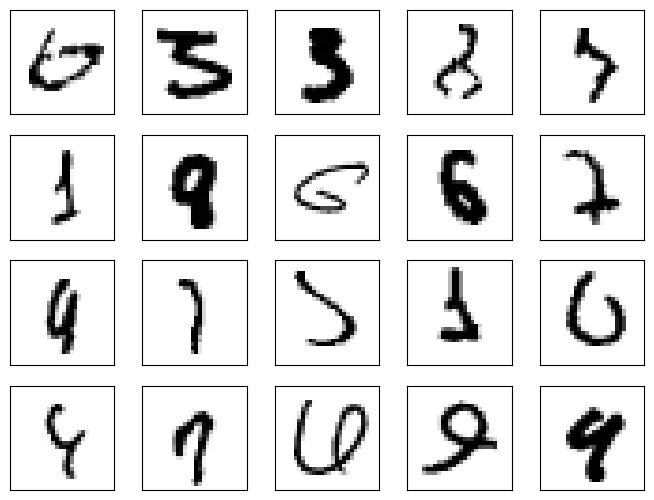

In [20]:
# coding: utf-8
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

print("calculating test accuracy ... ")
#sampled = 1000
#x_test = x_test[:sampled]
#t_test = t_test[:sampled]

classified_ids = []

acc = 0.0
batch_size = 100

for i in range(int(x_test.shape[0] / batch_size)):
    tx = x_test[i*batch_size:(i+1)*batch_size]
    tt = t_test[i*batch_size:(i+1)*batch_size]
    y = network.predict(tx, train_flg=False)
    y = np.argmax(y, axis=1)
    classified_ids.append(y)
    acc += np.sum(y == tt)

acc = acc / x_test.shape[0]
print("test accuracy:" + str(acc))

classified_ids = np.array(classified_ids)
classified_ids = classified_ids.flatten()

max_view = 20
current_view = 1

fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

mis_pairs = {}
for i, val in enumerate(classified_ids == t_test):
    if not val:
        ax = fig.add_subplot(4, 5, current_view, xticks=[], yticks=[])
        ax.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
        mis_pairs[current_view] = (t_test[i], classified_ids[i])

        current_view += 1
        if current_view > max_view:
            break

print("======= misclassified result =======")
print("{view index: (label, inference), ...}")
print(mis_pairs)

plt.show()

# 직접 학습하기

In [ ]:
# coding: utf-8
import sys, os
import numpy as np

class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01},
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)

        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)

        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))

        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1

            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]

            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))


In [ ]:
# coding: utf-8
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=20, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보관
network.save_params("deep_convnet_params.pkl")
print("Saved Network Parameters!")